In [1]:
import numpy as np
import pandas as pd
import os
import gzip
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Анализ

## Разбор сообщений

Смотрим на столбец `serv_mess`

In [3]:
# vibo: читаем предобработанный лог (index_col=0 считываем индексы тоже)
data_logs = pd.read_csv('/content/drive/MyDrive/minecraft/logs.csv', index_col=0)

In [4]:
data_logs

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN,NaN,NaN


In [5]:
# vibo: сводная статистика
data_logs[['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'plug_name', 'plug_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess,plug_name,plug_mess
count,6544,6544,6544,6544,6092,452,441
unique,10,1306,6,3,913,3,50
top,2023-03-06,21:13:39,Server thread,INFO,Preparing spawn area: 0%,WorldEdit,
freq,1093,115,5444,6392,674,218,44


Делаем новый датафрейм с которым будем работать

In [6]:
summary = data_logs[['date',	'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'user_authenticator_number', 'worker_main_number', 'async_chat_thread_number']]
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN


In [7]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6544 entries, 0 to 6581
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       6544 non-null   object 
 1   time                       6544 non-null   object 
 2   serv_teg_inf               6544 non-null   object 
 3   serv_teg                   6544 non-null   object 
 4   serv_mess                  6092 non-null   object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   19 non-null     float64
dtypes: float64(3), object(5)
memory usage: 460.1+ KB


In [8]:
# vibo: удаляем лишнее как и в блоке с анализом основных сообщений сервера
# плагин WorldGuard выдает свой тег в сообщения сервера отдельной группой 
summary = summary[summary['serv_teg_inf'] != 'WorldGuard Region I/O']
# vibo: ищем не нулевые строки
find_index = summary['serv_mess'].dropna().index
# vibo: фильтруем по ним датафрейм
summary = summary[summary.index.isin(find_index)]
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN


In [9]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6092 entries, 0 to 6581
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       6092 non-null   object 
 1   time                       6092 non-null   object 
 2   serv_teg_inf               6092 non-null   object 
 3   serv_teg                   6092 non-null   object 
 4   serv_mess                  6092 non-null   object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   19 non-null     float64
dtypes: float64(3), object(5)
memory usage: 428.3+ KB


In [10]:
summary[['date', 'time', 'serv_teg_inf', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_mess
count,6092,6092,6092,6092
unique,10,1285,5,913
top,2023-03-04,21:13:39,Server thread,Preparing spawn area: 0%
freq,1018,115,5003,674


### **ServerMain**

Смотрим на сообщения в категории `ServerMain`

In [11]:
summary[summary['serv_teg_inf'] == 'ServerMain']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6032,2023-03-09,18:37:58,ServerMain,INFO,Environment: authHost='https://authserver.moj...,NaN,NaN,NaN
6033,2023-03-09,18:38:00,ServerMain,INFO,Loaded 7 recipes,NaN,NaN,NaN
6299,2023-03-09,17:55:51,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN
6300,2023-03-09,17:55:54,ServerMain,INFO,Environment: authHost='https://authserver.moj...,NaN,NaN,NaN


In [12]:
summary[summary['serv_teg_inf'] == 'ServerMain'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 6301
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       86 non-null     object 
 1   time                       86 non-null     object 
 2   serv_teg_inf               86 non-null     object 
 3   serv_teg                   86 non-null     object 
 4   serv_mess                  86 non-null     object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   0 non-null      float64
dtypes: float64(3), object(5)
memory usage: 6.0+ KB


Видно, что последние столбцы из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [13]:
sub_summary = summary[summary['serv_teg_inf'] == 'ServerMain'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer
...,...,...,...,...,...
6032,2023-03-09,18:37:58,ServerMain,INFO,Environment: authHost='https://authserver.moj...
6033,2023-03-09,18:38:00,ServerMain,INFO,Loaded 7 recipes
6299,2023-03-09,17:55:51,ServerMain,INFO,Building unoptimized datafixer
6300,2023-03-09,17:55:54,ServerMain,INFO,Environment: authHost='https://authserver.moj...


In [14]:
sub_summary[sub_summary['serv_teg_inf'] == 'ServerMain'].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,86,86,86,86,86
unique,10,83,1,3,7
top,2023-03-04,21:31:48,ServerMain,INFO,Building unoptimized datafixer
freq,15,3,86,84,28


Самые популярные сообщения в категории `ServerMain`

In [15]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'ServerMain']['serv_mess'].value_counts()

 Building unoptimized datafixer                                                                                                                                                                                 28
 Environment: authHost='https://authserver.mojang.com', accountsHost='https://api.mojang.com', sessionHost='https://sessionserver.mojang.com', servicesHost='https://api.minecraftservices.com', name='PROD'    27
 Loaded 7 recipes                                                                                                                                                                                               27
 Failed to load properties from file: server.properties                                                                                                                                                          1
 Failed to load eula.txt                                                                                                                                    

Начало запуска сервера сопровождается сообщением `Building...`, при удачном старте выдается сообщение `Environment...` и `Loaded...`. При неудачном - сообщение об ошибке, `Failed...`.

In [16]:
plot_df = sub_summary[['date', 'serv_teg_inf', 'serv_mess']].groupby(['date', 'serv_teg_inf', 'serv_mess'])['serv_mess'].count().to_frame(name='count_mess')
plot_df

count_mess
date        serv_teg_inf serv_mess                                                     
2023-02-13  ServerMain    Building unoptimized datafixer                              4
                          Environment: authHost='https://authserver.moja...           3
                          Failed to load eula.txt                                     1
                          Failed to load properties from file: server.pr...           1
                          Found new data pack file/bukkit, loading it au...           1
                          Loaded 7 recipes                                            3
                          You need to agree to the EULA in order to run ...           1
2023-02-14  ServerMain    Building unoptimized datafixer                              2
                          Environment: authHost='https://authserver.moja...           2
                          Loaded 7 recipes                                            2
2023-02-17  ServerMain    Building unoptimized datafixer                              1
                          Environment: authHost='https://authserver.moja...           1
                          Loaded 7 recipes                                            1
2023-03-03  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-04  ServerMain    Building unoptimized datafixer                              5
                          Environment: authHost='https://authserver.moja...           5
                          Loaded 7 recipes                                            5
2023-03-05  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-06  ServerMain    Building unoptimized datafixer                              4
                          Environment: authHost='https://authserver.moja...           4
                          Loaded 7 recipes                                            4
2023-03-07  ServerMain    Building unoptimized datafixer                              1
                          Environment: authHost='https://authserver.moja...           1
                          Loaded 7 recipes                                            1
2023-03-08  ServerMain    Building unoptimized datafixer                              3
                          Environment: authHost='https://authserver.moja...           3
                          Loaded 7 recipes                                            3
2023-03-09  ServerMain    Building unoptimized datafixer                              2
                          Environment: authHost='https://authserver.moja...           2
                          Loaded 7 recipes                                            2

Посчитаем количество запусков и удачных стартов. Визуализируем результат.

In [17]:
plot_df = plot_df.reset_index()
plot_df = plot_df[['date', 'serv_mess', 'count_mess']]
plot_df

,date,serv_mess,count_mess
0,2023-02-13,Building unoptimized datafixer,4
1,2023-02-13,Environment: authHost='https://authserver.moj...,3
2,2023-02-13,Failed to load eula.txt,1
3,2023-02-13,Failed to load properties from file: server.p...,1
4,2023-02-13,"Found new data pack file/bukkit, loading it a...",1
5,2023-02-13,Loaded 7 recipes,3
6,2023-02-13,You need to agree to the EULA in order to run...,1
7,2023-02-14,Building unoptimized datafixer,2
8,2023-02-14,Environment: authHost='https://authserver.moj...,2
9,2023-02-14,Loaded 7 recipes,2


In [18]:
plot_df['is_building'] = plot_df['serv_mess'].map(lambda x: 'Building' in x)
ind_building = plot_df[plot_df['is_building'] == True].index

plot_df['is_loaded'] = plot_df['serv_mess'].map(lambda x: 'Loaded' in x)
ind_loaded = plot_df[plot_df['is_loaded'] == True].index

ind_plot = sorted(list(ind_building) + list(ind_loaded))
plot_df = plot_df[plot_df.index.isin(ind_plot)]
plot_df = plot_df[['date', 'serv_mess', 'count_mess']]
plot_df['serv_mess'] = plot_df['serv_mess'].map(lambda x: x.split()[0].lower())

#### Успешные и неуспешные старты сервера

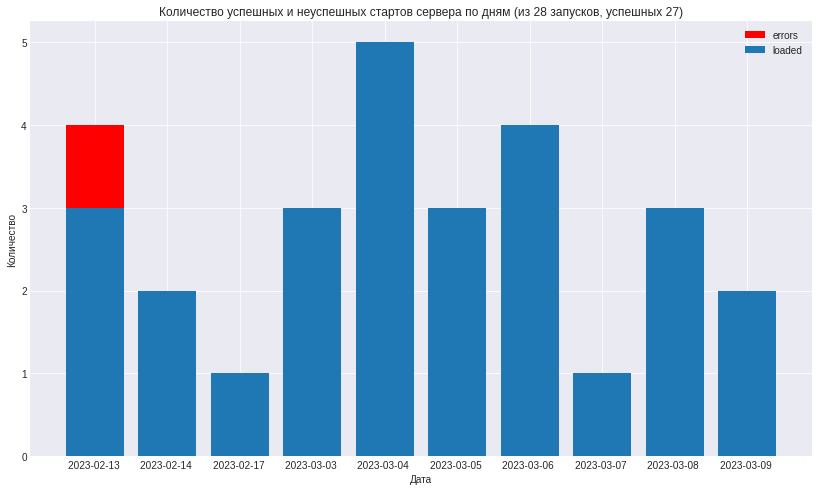

In [19]:
# vibo: data
groups_x = plot_df.groupby(['date']).count().index
values_y_building = plot_df['count_mess'][plot_df['serv_mess'] == 'building'].values
values_y_loaded = plot_df['count_mess'][plot_df['serv_mess'] == 'loaded'].values

# vibo: bar chart whith
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(14, 8))
  ax.bar(groups_x, values_y_building, label = "errors", color='red')
  ax.bar(groups_x, values_y_loaded, label = "loaded")

  plt.title(f'Количество успешных и неуспешных стартов сервера по дням (из {sum(values_y_building)} запусков, успешных {sum(values_y_loaded)})')
  ax.legend(loc='best')
  ax.set_xlabel('Дата')
  ax.set_ylabel('Количество')
  plt.show()

In [20]:
plot_df = plot_df.groupby(['serv_mess']).sum().reset_index()
plot_df = plot_df.sort_values('count_mess', ascending=False)

# vibo: считаем количество ошибок
find_list = list(plot_df['count_mess'].values)
count_errors = find_list[0] - find_list[1]

# vibo: создаем датафрейм с ошибками
plot_df_err = pd.DataFrame({'serv_mess': ['errors'], 'count_mess': [count_errors]})
# vibo: добавляем строку с ошибкой
plot_df = plot_df.append(plot_df_err, ignore_index=True)

plot_df

<ipython-input-20-79ac21a49c99>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(plot_df_err, ignore_index=True)


,serv_mess,count_mess
0,building,28
1,loaded,27
2,errors,1


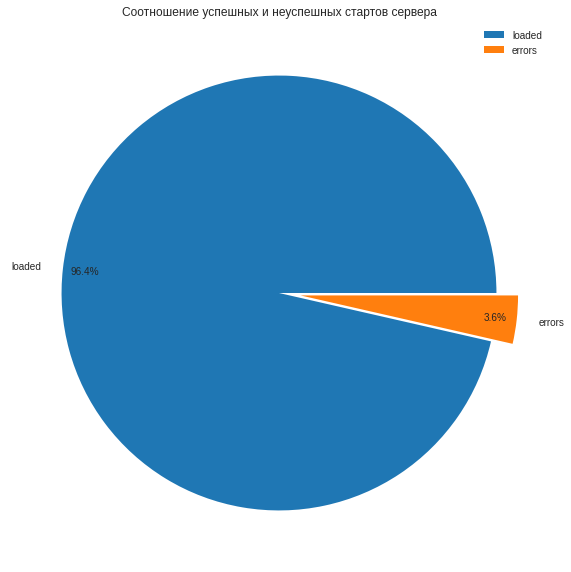

In [21]:
labels = plot_df['serv_mess'][1:3].values
value = plot_df['count_mess'][1:3].values

# vibo: pie chart
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(10, 10))
  explode = [0, 0.1]
  ax.pie(value, labels=labels, pctdistance=0.9, explode=explode, autopct='%1.1f%%', labeldistance=1.1)

  plt.title(f'Соотношение успешных и неуспешных стартов сервера')
  ax.legend(loc='best')
  plt.show()

### **Worker-Main**

Смотрим на сообщения в категории `Worker-Main`

In [22]:
summary[summary['serv_teg_inf'] == 'Worker-Main']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,4.0,NaN
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,4.0,NaN
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,6.0,NaN
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,NaN,7.0,NaN
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,NaN,6.0,NaN
...,...,...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,NaN,7.0,NaN
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,NaN,7.0,NaN
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,NaN,4.0,NaN
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,NaN,3.0,NaN


In [23]:
summary[summary['serv_teg_inf'] == 'Worker-Main'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 129 to 6510
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       891 non-null    object 
 1   time                       891 non-null    object 
 2   serv_teg_inf               891 non-null    object 
 3   serv_teg                   891 non-null    object 
 4   serv_mess                  891 non-null    object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         891 non-null    float64
 7   async_chat_thread_number   0 non-null      float64
dtypes: float64(3), object(5)
memory usage: 62.6+ KB


Видно, что два столбца из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [24]:
sub_summary = summary[summary['serv_teg_inf'] == 'Worker-Main'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'worker_main_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,worker_main_number
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,6.0
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,7.0
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,6.0
...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,7.0
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,7.0
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,4.0
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,3.0


In [25]:
sub_summary[sub_summary['serv_teg_inf'] == 'Worker-Main'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,891,891,891,891,891
unique,10,213,1,1,85
top,2023-03-04,18:28:23,Worker-Main,INFO,Preparing spawn area: 0%
freq,154,17,891,891,674


Самые популярные сообщения в категории `Worker-Main`

In [26]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'Worker-Main']['serv_mess'].value_counts()

 Preparing spawn area: 0%     674
 Preparing spawn area: 9%       8
 Preparing spawn area: 4%       7
 Preparing spawn area: 1%       7
 Preparing spawn area: 83%      7
                             ... 
 Preparing spawn area: 66%      1
 Preparing spawn area: 56%      1
 Preparing spawn area: 42%      1
 Preparing spawn area: 15%      1
 Preparing spawn area: 78%      1
Name: serv_mess, Length: 85, dtype: int64

In [29]:
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,worker_main_number
129,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
130,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,4.0
131,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,6.0
132,2023-02-13,21:34:31,Worker-Main,INFO,Preparing spawn area: 0%,7.0
133,2023-02-13,21:34:32,Worker-Main,INFO,Preparing spawn area: 0%,6.0
...,...,...,...,...,...,...
6506,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 13%,7.0
6507,2023-03-09,17:56:40,Worker-Main,INFO,Preparing spawn area: 35%,7.0
6508,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 62%,4.0
6509,2023-03-09,17:56:41,Worker-Main,INFO,Preparing spawn area: 83%,3.0


### **User Authenticator**

Смотрим на сообщения в категории `User Authenticator`

In [30]:
summary[summary['serv_teg_inf'] == 'User Authenticator']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0,NaN,NaN
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0,NaN,NaN
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0,NaN,NaN
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0,NaN,NaN
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0,NaN,NaN


In [31]:
summary[summary['serv_teg_inf'] == 'User Authenticator'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 393 to 6577
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       93 non-null     object 
 1   time                       93 non-null     object 
 2   serv_teg_inf               93 non-null     object 
 3   serv_teg                   93 non-null     object 
 4   serv_mess                  93 non-null     object 
 5   user_authenticator_number  93 non-null     float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   0 non-null      float64
dtypes: float64(3), object(5)
memory usage: 6.5+ KB


Видно, что последние два столбца из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [32]:
sub_summary = summary[summary['serv_teg_inf'] == 'User Authenticator'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'user_authenticator_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0
...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0


In [33]:
sub_summary[sub_summary['serv_teg_inf'] == 'User Authenticator'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,93,93,93,93,93
unique,10,93,1,1,21
top,2023-03-06,21:49:48,User Authenticator,INFO,UUID of player testing1 is 4e9071c3-79ab-3a3a...
freq,24,1,93,93,15


Самые популярные сообщения в категории `User Authenticator`

In [34]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].value_counts()

 UUID of player testing1 is 4e9071c3-79ab-3a3a-ab83-2e04eacd6854            15
 UUID of player YOUTUBE_plaY is 56eb670a-4ed0-3009-9bc9-00d047fbaeff        14
 UUID of player amogoos is bb8d3a15-62ea-3dd7-8df8-776e0930f557             12
 UUID of player testing2 is 5e20431e-cf2a-314e-a557-c5525d567366             9
 UUID of player vibo is f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9                 7
 UUID of player rex is 74d83d51-5bf6-37fb-8395-9a0590a59259                  6
 UUID of player testing3 is 0c9c0d31-79b7-3cc6-894a-5b40d339bd72             4
 UUID of player ARTEXX is ee86a614-d39f-3a50-aef4-d8029433b0f5               3
 UUID of player aaaaa is 77cc7b98-f829-305b-9a13-dbb088fbd0f5                3
 UUID of player Fredi is 1ee24d02-4446-35e1-84c8-4b785c1bae33                3
 UUID of player vibO is 426ba0c3-6437-3e82-b36b-ca953fb41a42                 3
 UUID of player gggggg102 is d755a875-1b70-3b66-bd19-b2b67e593159            3
 UUID of player _Rocket5500_ is a6be4875-0cf6-3c5a-9

#### User Name & UUID

Посмотрим на сообщения в категории `User Authenticator`, видим, что можем выделить `user_name` и `UUID`

In [35]:
summary[summary['serv_teg_inf'] == 'User Authenticator']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number
393,2023-02-13,21:49:48,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
566,2023-02-13,22:01:24,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
914,2023-02-14,23:53:33,User Authenticator,INFO,UUID of player vibO is 426ba0c3-6437-3e82-b36...,1.0,NaN,NaN
1095,2023-02-17,19:05:26,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,1.0,NaN,NaN
1101,2023-02-17,19:07:53,User Authenticator,INFO,UUID of player YOUTUBE_plaY is 56eb670a-4ed0-...,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...
6535,2023-03-09,17:58:27,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,1.0,NaN,NaN
6540,2023-03-09,18:01:54,User Authenticator,INFO,UUID of player ARTEEXX is 8c767e42-029f-3dee-...,2.0,NaN,NaN
6546,2023-03-09,18:04:00,User Authenticator,INFO,UUID of player AARRTTEEXX is 843fa0f7-aebb-3f...,3.0,NaN,NaN
6553,2023-03-09,18:16:03,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,4.0,NaN,NaN


In [36]:
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date'])['date'].count().to_frame(name='count_authent').reset_index()

,date,count_authent
0,2023-02-13,2
1,2023-02-14,1
2,2023-02-17,8
3,2023-03-03,11
4,2023-03-04,3
5,2023-03-05,17
6,2023-03-06,24
7,2023-03-07,10
8,2023-03-08,10
9,2023-03-09,7


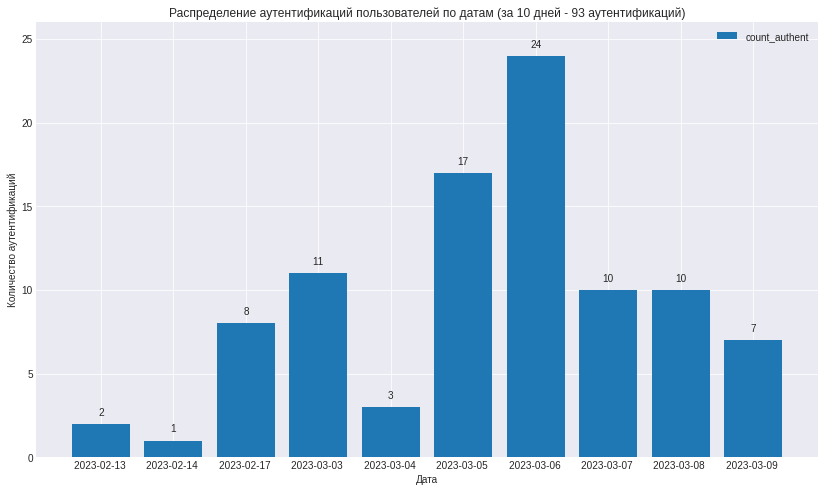

In [37]:
# vibo: data
plot_df = summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date'])['date'].count().to_frame(name='count_authent').reset_index()
groups_x = plot_df['date'].values
values_y = plot_df['count_authent'].values

# vibo: bar chart whith total value labels
# vibo: здесь можно поиграться с номером темы (0-27)
plot_style = 16
with plt.style.context(plt.style.available[plot_style]):
  fig, ax = plt.subplots(figsize=(14, 8))
  ax.bar(groups_x, values_y, label = "count_authent")

  for i, total in enumerate(values_y):
    ax.text(i, total + 0.5, values_y[i], ha='center')

  plt.title(f'Распределение аутентификаций пользователей по датам (за {len(groups_x)} дней - {sum(values_y)} аутентификаций)')
  ax.legend(loc='best')
  ax.set_xlabel('Дата')
  ax.set_ylim(0, 26)
  ax.set_ylabel('Количество аутентификаций')
  plt.show()

Пример расшифровки UUID из интернета

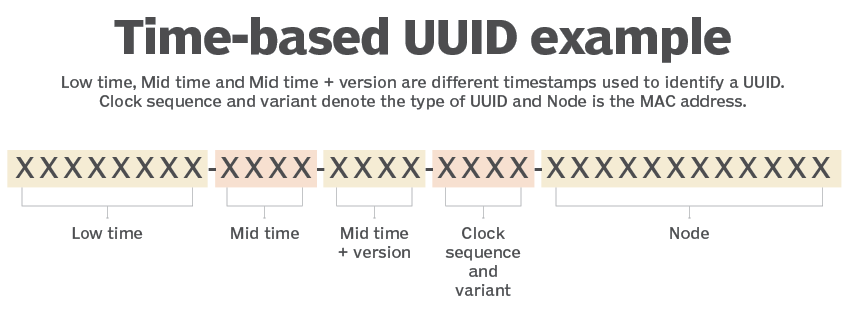

In [38]:
# vibo: выделяем имя пользователя и его UUID
summary['user_name'] = summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].map(lambda x: x.split()[3])
summary['uuid'] = summary[summary['serv_teg_inf'] == 'User Authenticator']['serv_mess'].map(lambda x: x.split()[5])
summary[summary['serv_teg_inf'] == 'User Authenticator'][['date', 'user_authenticator_number', 'user_name', 'uuid']]

,date,user_authenticator_number,user_name,uuid
393,2023-02-13,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
566,2023-02-13,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
914,2023-02-14,1.0,vibO,426ba0c3-6437-3e82-b36b-ca953fb41a42
1095,2023-02-17,1.0,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
1101,2023-02-17,2.0,YOUTUBE_plaY,56eb670a-4ed0-3009-9bc9-00d047fbaeff
...,...,...,...,...
6535,2023-03-09,1.0,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5
6540,2023-03-09,2.0,ARTEEXX,8c767e42-029f-3dee-99c9-1bccb126c2d8
6546,2023-03-09,3.0,AARRTTEEXX,843fa0f7-aebb-3f41-ba00-efc9ea7989f8
6553,2023-03-09,4.0,ARTEXX,ee86a614-d39f-3a50-aef4-d8029433b0f5


UUID привязан к имени пользователя

In [39]:
# vibo: суммарное количество аутентификаций пользователей за период
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['serv_mess']).size().sort_values(ascending=False)

serv_mess
 UUID of player testing1 is 4e9071c3-79ab-3a3a-ab83-2e04eacd6854            15
 UUID of player YOUTUBE_plaY is 56eb670a-4ed0-3009-9bc9-00d047fbaeff        14
 UUID of player amogoos is bb8d3a15-62ea-3dd7-8df8-776e0930f557             12
 UUID of player testing2 is 5e20431e-cf2a-314e-a557-c5525d567366             9
 UUID of player vibo is f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9                 7
 UUID of player rex is 74d83d51-5bf6-37fb-8395-9a0590a59259                  6
 UUID of player testing3 is 0c9c0d31-79b7-3cc6-894a-5b40d339bd72             4
 UUID of player ARTEXX is ee86a614-d39f-3a50-aef4-d8029433b0f5               3
 UUID of player Fredi is 1ee24d02-4446-35e1-84c8-4b785c1bae33                3
 UUID of player vibO is 426ba0c3-6437-3e82-b36b-ca953fb41a42                 3
 UUID of player aaaaa is 77cc7b98-f829-305b-9a13-dbb088fbd0f5                3
 UUID of player gggggg102 is d755a875-1b70-3b66-bd19-b2b67e593159            3
 UUID of player LOLOTUK is 351abe30-df95-3

### **Async Chat Thread**

Смотрим на сообщения в категории `Async Chat Thread`

In [40]:
summary[summary['serv_teg_inf'] == 'Async Chat Thread']

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,user_name,uuid
1153,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!,NaN,NaN,0.0,NaN,NaN
1154,2023-02-17,19:41:54,Async Chat Thread,INFO,[Not Secure] <vibo> ты можешь выдать мне прав...,NaN,NaN,0.0,NaN,NaN
1155,2023-02-17,19:42:08,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> да да,NaN,NaN,0.0,NaN,NaN
1157,2023-02-17,19:43:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> всё дал,NaN,NaN,2.0,NaN,NaN
1164,2023-02-17,19:45:47,Async Chat Thread,INFO,[Not Secure] <vibo> спасибо! все получилось,NaN,NaN,4.0,NaN,NaN
1169,2023-02-17,19:48:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> давй пвп,NaN,NaN,6.0,NaN,NaN
1170,2023-02-17,19:48:36,Async Chat Thread,INFO,[Not Secure] <vibo> давай,NaN,NaN,6.0,NaN,NaN
1173,2023-02-17,19:49:04,Async Chat Thread,INFO,[Not Secure] <vibo> ты готов?,NaN,NaN,6.0,NaN,NaN
1191,2023-02-17,20:05:41,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> что будем делать,NaN,NaN,8.0,NaN,NaN
1192,2023-02-17,20:07:01,Async Chat Thread,INFO,[Not Secure] <vibo> я убрал лаву,NaN,NaN,10.0,NaN,NaN


In [41]:
summary[summary['serv_teg_inf'] == 'Async Chat Thread'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 1153 to 5744
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       19 non-null     object 
 1   time                       19 non-null     object 
 2   serv_teg_inf               19 non-null     object 
 3   serv_teg                   19 non-null     object 
 4   serv_mess                  19 non-null     object 
 5   user_authenticator_number  0 non-null      float64
 6   worker_main_number         0 non-null      float64
 7   async_chat_thread_number   19 non-null     float64
 8   user_name                  0 non-null      object 
 9   uuid                       0 non-null      object 
dtypes: float64(3), object(7)
memory usage: 1.6+ KB


Видно, что некоторые столбцы из рассмотрения можно сразу исключить, выделим данные в отдельный датафрейм

In [42]:
sub_summary = summary[summary['serv_teg_inf'] == 'Async Chat Thread'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'async_chat_thread_number']]
sub_summary

,date,time,serv_teg_inf,serv_teg,serv_mess,async_chat_thread_number
1153,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!,0.0
1154,2023-02-17,19:41:54,Async Chat Thread,INFO,[Not Secure] <vibo> ты можешь выдать мне прав...,0.0
1155,2023-02-17,19:42:08,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> да да,0.0
1157,2023-02-17,19:43:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> всё дал,2.0
1164,2023-02-17,19:45:47,Async Chat Thread,INFO,[Not Secure] <vibo> спасибо! все получилось,4.0
1169,2023-02-17,19:48:23,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> давй пвп,6.0
1170,2023-02-17,19:48:36,Async Chat Thread,INFO,[Not Secure] <vibo> давай,6.0
1173,2023-02-17,19:49:04,Async Chat Thread,INFO,[Not Secure] <vibo> ты готов?,6.0
1191,2023-02-17,20:05:41,Async Chat Thread,INFO,[Not Secure] <YOUTUBE_plaY> что будем делать,8.0
1192,2023-02-17,20:07:01,Async Chat Thread,INFO,[Not Secure] <vibo> я убрал лаву,10.0


In [43]:
sub_summary[sub_summary['serv_teg_inf'] == 'Async Chat Thread'][['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess
count,19,19,19,19,19
unique,4,19,1,1,19
top,2023-02-17,19:41:22,Async Chat Thread,INFO,[Not Secure] <vibo> привет!!!
freq,12,1,19,19,1


Самые популярные сообщения в категории `Async Chat Thread`

In [44]:
# vibo: найдем самые популярные сообщения в категории
summary[summary['serv_teg_inf'] == 'Async Chat Thread']['serv_mess'].value_counts()


 [Not Secure] <vibo> привет!!!                                                      1
 [Not Secure] <YOUTUBE_plaY> выбераеш ты                                            1
 [Not Secure] <vibo> как ты поменял цвет маяка?                                     1
 [Not Secure] <amogoos> дааааааааада                                                1
 [Not Secure] <vibo> ты меня слышышь?                                               1
 [Not Secure] <vibo> прием                                                          1
 [Not Secure] <amogoos> amogoos red                                                 1
 [Not Secure] <rex> fhgfjhgj                                                        1
 [Not Secure] <vibo> хочу понять как делать спавн поинт для новых игроков           1
 [Not Secure] <vibo> я убрал лаву                                                   1
 [Not Secure] <vibo> ты можешь выдать мне права админа на твоем сервере?            1
 [Not Secure] <YOUTUBE_plaY> что будем делать         

#### Игровой чат

In [45]:
summary[summary['serv_teg_inf'] == 'Async Chat Thread'][['date', 'time', 'user_name', 'serv_mess', 'async_chat_thread_number']]

,date,time,user_name,serv_mess,async_chat_thread_number
1153,2023-02-17,19:41:22,NaN,[Not Secure] <vibo> привет!!!,0.0
1154,2023-02-17,19:41:54,NaN,[Not Secure] <vibo> ты можешь выдать мне прав...,0.0
1155,2023-02-17,19:42:08,NaN,[Not Secure] <YOUTUBE_plaY> да да,0.0
1157,2023-02-17,19:43:23,NaN,[Not Secure] <YOUTUBE_plaY> всё дал,2.0
1164,2023-02-17,19:45:47,NaN,[Not Secure] <vibo> спасибо! все получилось,4.0
1169,2023-02-17,19:48:23,NaN,[Not Secure] <YOUTUBE_plaY> давй пвп,6.0
1170,2023-02-17,19:48:36,NaN,[Not Secure] <vibo> давай,6.0
1173,2023-02-17,19:49:04,NaN,[Not Secure] <vibo> ты готов?,6.0
1191,2023-02-17,20:05:41,NaN,[Not Secure] <YOUTUBE_plaY> что будем делать,8.0
1192,2023-02-17,20:07:01,NaN,[Not Secure] <vibo> я убрал лаву,10.0


### Обзор действий игрока

Достаточно ввести имя в строку ниже, чтобы получить полную информацию.

In [46]:
name = 'amogoos'

In [47]:
# vibo: найдем все упоминания игрока в сообщениях
summary[f'is_{name}'] = summary['serv_mess'].map(lambda x: name in x)
ind_name = summary[summary[f'is_{name}'] == True].index
summary[summary.index.isin(ind_name)]

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,user_name,uuid,is_amogoos
3180,2023-03-05,12:57:45,Server thread,INFO,Made amogoos a server operator,NaN,NaN,NaN,NaN,NaN,True
3181,2023-03-05,12:58:56,User Authenticator,INFO,UUID of player amogoos is bb8d3a15-62ea-3dd7-...,1.0,NaN,NaN,amogoos,bb8d3a15-62ea-3dd7-8df8-776e0930f557,True
3182,2023-03-05,12:58:56,Server thread,INFO,amogoos joined the game,NaN,NaN,NaN,NaN,NaN,True
3183,2023-03-05,12:58:57,Server thread,INFO,amogoos[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN,NaN,NaN,True
3184,2023-03-05,13:01:16,Async Chat Thread,INFO,[Not Secure] <amogoos> amogoos red,NaN,NaN,0.0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
5101,2023-03-07,20:21:46,Server thread,INFO,amogoos joined the game,NaN,NaN,NaN,NaN,NaN,True
5102,2023-03-07,20:21:46,Server thread,INFO,amogoos[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN,NaN,NaN,True
5103,2023-03-07,20:57:04,Server thread,INFO,amogoos has completed the challenge [Serious ...,NaN,NaN,NaN,NaN,NaN,True
5104,2023-03-07,21:02:46,Server thread,INFO,amogoos lost connection: Disconnected,NaN,NaN,NaN,NaN,NaN,True


In [48]:
# vibo: уникальные аутентифицированные пользователи
sorted(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['user_name'].unique()))

['AARRTTEEXX',
 'ARTEEXX',
 'ARTEXX',
 'Fredi',
 'LOLOTUK',
 'Umni4ok100200',
 'YOUTUBE_plaY',
 '_Rocket5500_',
 'aaaaa',
 'amogoos',
 'amogoos_red',
 'amogoos_red15050',
 'gggggg102',
 'rex',
 'test_name_1',
 'testing1',
 'testing2',
 'testing3',
 'testing4',
 'vibO',
 'vibo']

In [49]:
# vibo: уникальные UUID
sorted(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['uuid'].unique()))

['0c9c0d31-79b7-3cc6-894a-5b40d339bd72',
 '1ee24d02-4446-35e1-84c8-4b785c1bae33',
 '319be620-93f2-3b87-8414-d9f733460955',
 '351abe30-df95-37d4-940e-b868831fc026',
 '426ba0c3-6437-3e82-b36b-ca953fb41a42',
 '4e9071c3-79ab-3a3a-ab83-2e04eacd6854',
 '56eb670a-4ed0-3009-9bc9-00d047fbaeff',
 '5e20431e-cf2a-314e-a557-c5525d567366',
 '74d83d51-5bf6-37fb-8395-9a0590a59259',
 '77cc7b98-f829-305b-9a13-dbb088fbd0f5',
 '843fa0f7-aebb-3f41-ba00-efc9ea7989f8',
 '8c767e42-029f-3dee-99c9-1bccb126c2d8',
 '90c58b0a-047b-3f41-a2eb-0b295facaf2a',
 '9f566d31-b9cd-3069-9068-967914755363',
 'a101608a-3944-3398-a11e-16211546e19a',
 'a6be4875-0cf6-3c5a-9d9f-b226ad3a4bc1',
 'b78a67d1-e667-3841-a463-64fdf66f2484',
 'bb8d3a15-62ea-3dd7-8df8-776e0930f557',
 'd755a875-1b70-3b66-bd19-b2b67e593159',
 'ee86a614-d39f-3a50-aef4-d8029433b0f5',
 'f4a7e80b-36fa-3e7a-814b-9824a8ccd5f9']

In [50]:
# vibo: количество уникальных аутентицированных пользователей
len(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['user_name'].unique()))

21

In [51]:
len(list(summary[summary['serv_teg_inf'] == 'User Authenticator']['uuid'].unique()))

21

In [52]:
# vibo: количество аутентификаций в группировке по пользователям
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['user_name']).size().sort_values(ascending=False)

user_name
testing1            15
YOUTUBE_plaY        14
amogoos             12
testing2             9
vibo                 7
rex                  6
testing3             4
ARTEXX               3
Fredi                3
vibO                 3
aaaaa                3
gggggg102            3
LOLOTUK              2
_Rocket5500_         2
testing4             1
AARRTTEEXX           1
test_name_1          1
amogoos_red15050     1
ARTEEXX              1
Umni4ok100200        1
amogoos_red          1
dtype: int64

In [53]:
# vibo: количество аутентицикаций в день
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date']).size()

date
2023-02-13      2
2023-02-14      1
2023-02-17      8
2023-03-03     11
2023-03-04      3
2023-03-05     17
2023-03-06     24
2023-03-07     10
2023-03-08     10
2023-03-09      7
dtype: int64

In [54]:
# vibo: количество аутентификаций пользователей по дням с группировкой по пользователям
summary[summary['serv_teg_inf'] == 'User Authenticator'].groupby(['date', 'user_name'])[['user_name']].size()

date         user_name       
2023-02-13   vibO                 2
2023-02-14   vibO                 1
2023-02-17   YOUTUBE_plaY         5
             vibo                 3
2023-03-03   LOLOTUK              2
             YOUTUBE_plaY         6
             rex                  3
2023-03-04   rex                  3
2023-03-05   YOUTUBE_plaY         3
             amogoos              7
             amogoos_red          1
             amogoos_red15050     1
             gggggg102            1
             testing1             1
             vibo                 3
2023-03-06   amogoos              2
             testing1            13
             testing2             7
             testing3             1
             testing4             1
2023-03-07   Fredi                3
             amogoos              3
             gggggg102            2
             test_name_1          1
             testing1             1
2023-03-08   Umni4ok100200        1
             aaaaa                

### Плагины и их сообщения

Также можно продолжить поиск информации уже по установленным плагинам (столбец `plug_mess`).

In [56]:
# vibo: читаем предобработанный лог (index_col=0 считываем индексы тоже)
data_logs = pd.read_csv('/content/drive/MyDrive/minecraft/logs.csv', index_col=0)

In [57]:
data_logs

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
0,2023-02-13,21:31:47,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
1,2023-02-13,21:31:48,ServerMain,ERROR,Failed to load properties from file: server.p...,NaN,NaN,NaN,NaN,NaN
2,2023-02-13,21:31:48,ServerMain,WARN,Failed to load eula.txt,NaN,NaN,NaN,NaN,NaN
3,2023-02-13,21:31:48,ServerMain,INFO,You need to agree to the EULA in order to run...,NaN,NaN,NaN,NaN,NaN
5,2023-02-13,21:34:03,ServerMain,INFO,Building unoptimized datafixer,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6577,2023-03-09,18:50:50,User Authenticator,INFO,UUID of player ARTEXX is ee86a614-d39f-3a50-a...,5.0,NaN,NaN,NaN,NaN
6578,2023-03-09,18:50:50,Server thread,INFO,ARTEXX joined the game,NaN,NaN,NaN,NaN,NaN
6579,2023-03-09,18:50:50,Server thread,INFO,ARTEXX[/[0:0:0:0:0:0:0:1,NaN,NaN,NaN,NaN,NaN
6580,2023-03-09,18:52:31,Server thread,INFO,ARTEXX issued server command: /farwand,NaN,NaN,NaN,NaN,NaN


In [58]:
# vibo: сводная статистика
data_logs[['date', 'time', 'serv_teg_inf', 'serv_teg', 'serv_mess', 'plug_name', 'plug_mess']].describe()

,date,time,serv_teg_inf,serv_teg,serv_mess,plug_name,plug_mess
count,6544,6544,6544,6544,6092,452,441
unique,10,1306,6,3,913,3,50
top,2023-03-06,21:13:39,Server thread,INFO,Preparing spawn area: 0%,WorldEdit,
freq,1093,115,5444,6392,674,218,44


#### WorldEdit

In [59]:
summary = data_logs[data_logs['plug_name'] == 'WorldEdit']
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
3321,2023-03-05,14:58:48,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,Loading WorldEdit v7.2.13+46576cc
3322,2023-03-05,14:58:48,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,NaN
3323,2023-03-05,14:58:48,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,Default configuration file written: config.yml
3324,2023-03-05,14:58:48,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,Enabling WorldEdit v7.2.13+46576cc
3329,2023-03-05,14:58:50,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,==============================================...
...,...,...,...,...,...,...,...,...,...,...
6331,2023-03-09,17:56:12,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,"All of your plugins should still work, and the"
6332,2023-03-09,17:56:12,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,Paper community will gladly help you fix any ...
6333,2023-03-09,17:56:12,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,
6334,2023-03-09,17:56:12,Server thread,INFO,NaN,NaN,NaN,NaN,WorldEdit,Join the Paper Community @ https://papermc.io


In [60]:
summary['plug_mess'].value_counts()

                                                                                 44
====================================================                             22
Loading WorldEdit v7.2.13+46576cc                                                11
 features for server owners to enhance their server.                             11
 Join the Paper Community @ https://papermc.io                                   11
 Paper community will gladly help you fix any issues.                            11
 All of your plugins should still work, and the                                  11
 better at diagnosing lag problems over v1.                                      11
 Paper includes Timings v2, which is significantly                               11
 bug fixes, security enhancements and optional                                   11
 Paper offers significant performance improvements,                              11
 as your server software.                                                   

#### WorldGuard

In [61]:
summary = data_logs[data_logs['plug_name'] == 'WorldGuard']
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
4047,2023-03-06,21:00:03,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Loading WorldGuard v7.0.8-beta-01+cbb2ba7
4215,2023-03-06,21:00:19,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Enabling WorldGuard v7.0.8-beta-01+cbb2ba7
4216,2023-03-06,21:00:19,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Default configuration file written: config.yml
4217,2023-03-06,21:00:19,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Default configuration file written: config_wor...
4218,2023-03-06,21:00:19,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Default configuration file written: blacklist.txt
...,...,...,...,...,...,...,...,...,...,...
6525,2023-03-09,17:56:43,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,(world_the_end) Lighters are PERMITTED.
6526,2023-03-09,17:56:43,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,(world_the_end) Lava fire is PERMITTED.
6527,2023-03-09,17:56:43,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,(world_the_end) Fire spread is UNRESTRICTED.
6528,2023-03-09,17:56:43,Server thread,INFO,NaN,NaN,NaN,NaN,WorldGuard,Loaded configuration for world 'world_the_end'


In [62]:
summary['plug_mess'].value_counts()

Region data changes made in 'world' have been background saved                                                                             11
Loading region data...                                                                                                                     10
Loading WorldGuard v7.0.8-beta-01+cbb2ba7                                                                                                   9
(world_nether) Lava fire is PERMITTED.                                                                                                      9
Loaded configuration for world 'world_the_end'                                                                                              9
(world_the_end) Fire spread is UNRESTRICTED.                                                                                                9
(world_the_end) Lava fire is PERMITTED.                                                                                                     9
(world

#### HolographicDisplays

In [63]:
summary = data_logs[data_logs['plug_name'] == 'HolographicDisplays']
summary

,date,time,serv_teg_inf,serv_teg,serv_mess,user_authenticator_number,worker_main_number,async_chat_thread_number,plug_name,plug_mess
4314,2023-03-06,22:46:45,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Loading HolographicDisplays v3.0.0
4483,2023-03-06,22:47:01,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Enabling HolographicDisplays v3.0.0
4503,2023-03-06,22:47:02,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Found a new version available: v3.0.1
4504,2023-03-06,22:47:02,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Download it on Bukkit Dev:
4505,2023-03-06,22:47:02,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,https://dev.bukkit.org/projects/holographic-di...
4520,2023-03-06,22:55:04,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Disabling HolographicDisplays v3.0.0
4548,2023-03-06,23:02:37,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Loading HolographicDisplays v3.0.0
4716,2023-03-06,23:02:53,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Enabling HolographicDisplays v3.0.0
4736,2023-03-06,23:02:54,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Found a new version available: v3.0.1
4737,2023-03-06,23:02:54,Server thread,INFO,NaN,NaN,NaN,NaN,HolographicDisplays,Download it on Bukkit Dev:


In [64]:
summary['plug_mess'].value_counts()

Loading HolographicDisplays v3.0.0                      8
Enabling HolographicDisplays v3.0.0                     8
Found a new version available: v3.0.1                   8
Download it on Bukkit Dev:                              8
https://dev.bukkit.org/projects/holographic-displays    8
Disabling HolographicDisplays v3.0.0                    3
Name: plug_mess, dtype: int64